## regresion lineal Daniel alejandro herrera mejia

##### Dataset: Contiene información técnica y de mercado de automóviles. El objetivo es predecir el precio del automóvil en función de sus atributos

In [462]:
# Importar librerías necesarias
import statsmodels.api as sm
import pandas as pd                   # Manipulación y análisis de datos en tablas
import numpy as np                    # Operaciones matemáticas y generación de datos aleatorios
import matplotlib.pyplot as plt       # Visualización de datos (gráficos)
from sklearn.linear_model import LinearRegression     # Modelo de regresión lineal
from sklearn.model_selection import train_test_split  # División de datos en entrenamiento y prueba
from sklearn.metrics import mean_squared_error, r2_score  # Métricas de evaluación del modelo

#Cargamos el dataset
data = pd.read_csv("car details v4.csv")

##### Aunque no es necesario,  traducir el nombre de cada campo para tener una mejor comprensión.

In [465]:
data.rename(columns={
    "Make": "Marca",
    "Model": "Modelo",
    "Price": "Precio",
    "Year": "Año",
    "Kilometer": "Kilometraje",
    "Fuel Type": "Tipo Combustible",
    "Transmission": "Transmisión",
    "Location": "Ubicación",
    "Color": "Color",
    "Owner": "Propietario",
    "Seller Type": "Tipo Vendedor",
    "Engine": "Motor",
    "Max Power": "Potencia Máxima",
    "Max Torque": "Torque Máximo",
    "Drivetrain": "Tracción",
    "Length": "Longitud",
    "Width": "Ancho",
    "Height": "Altura",
    "Seating Capacity": "Capacidad Pasajeros",
    "Fuel Tank Capacity": "Capacidad Tanque"
}, inplace=True)


In [467]:
#contamos el numero de filas y columnas
data.shape

(2059, 20)

##### realizaremos un análisis exploratorio de datos (EDA) donde vamos a corregir o eliminar datos incorrectos, duplicados o incompletos. 

In [470]:
#eliminamos valores duplicados
data = data.drop_duplicates()
#numero total de filas despues de eliminar valores duplicados
data.shape

(2059, 20)

In [472]:
# Lista manual de columnas numéricas
columnas_numericas = [
    "Precio", "Año", "Kilometraje",
    "Longitud", "Ancho", "Altura",
    "Capacidad Pasajeros", "Capacidad Tanque"
]


# Creamos una copia solo con las numéricas que vamos a tratar
numericas = data[columnas_numericas].copy()

# -----------------------------
# Corregimos valores atípicos con IQR
# -----------------------------
for col in numericas.columns:
    Q1 = numericas[col].quantile(0.25)
    Q3 = numericas[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    numericas[col] = numericas[col].clip(lower, upper)

# -----------------------------
# se Transformar columnas sesgadas
# -----------------------------
for col in numericas.columns:
    if numericas[col].nunique() <= 1 or numericas[col].std() == 0:
        #print(f"{col}: sin variabilidad, no se transforma")
        continue
    
    val_skew = skew(numericas[col].dropna())
    #print(f"{col} - Sesgo: {val_skew:.2f}")
    
    if abs(val_skew) > 1:
        numericas[col] = np.log1p(numericas[col])
        #print(f"Transformación logarítmica aplicada a {col}")

# -----------------------------
# Reemplazamos en el DataFrame original solo las columnas numéricas
# -----------------------------
data[columnas_numericas] = numericas



verificamos la existencia de valores nulos

In [475]:

#identificamos que columnas tienen valores nulos y corregimos
data.isna().sum()

Marca                    0
Modelo                   0
Precio                   0
Año                      0
Kilometraje              0
Tipo Combustible         0
Transmisión              0
Ubicación                0
Color                    0
Propietario              0
Tipo Vendedor            0
Motor                   80
Potencia Máxima         80
Torque Máximo           80
Tracción               136
Longitud                64
Ancho                   64
Altura                  64
Capacidad Pasajeros     64
Capacidad Tanque       113
dtype: int64

In [477]:
# Copiamos el DataFrame
data_limpia = data.copy()

# Detectar columnas numéricas y categóricas
columnas_numericas = data_limpia.select_dtypes(include=['number']).columns
columnas_categoricas = data_limpia.select_dtypes(include=['object']).columns

# Imputar valores numéricos con la media
imputer_num = SimpleImputer(strategy='mean')
data_limpia[columnas_numericas] = imputer_num.fit_transform(data_limpia[columnas_numericas])

# Imputar valores categóricos con la moda (valor más frecuente)
imputer_cat = SimpleImputer(strategy='most_frequent')
data_limpia[columnas_categoricas] = imputer_cat.fit_transform(data_limpia[columnas_categoricas])


validamos si tenemos valore nulos


In [480]:
data_limpia.isna().sum()


Marca                  0
Modelo                 0
Precio                 0
Año                    0
Kilometraje            0
Tipo Combustible       0
Transmisión            0
Ubicación              0
Color                  0
Propietario            0
Tipo Vendedor          0
Motor                  0
Potencia Máxima        0
Torque Máximo          0
Tracción               0
Longitud               0
Ancho                  0
Altura                 0
Capacidad Pasajeros    0
Capacidad Tanque       0
dtype: int64

In [482]:
#hacemos elresumen estadístico rápido de los datos numéricos de la tabla 
data_limpia.describe()

,Precio,Año,Kilometraje,Longitud,Ancho,Altura,Capacidad Pasajeros,Capacidad Tanque
count,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000,2059.0,2059.000000
mean,13.763621,2016.446576,52328.829043,4280.860652,1764.814787,1591.326817,5.0,51.812718
std,0.891232,3.261902,30173.855986,435.524350,123.788408,132.698990,0.0,14.176011
min,10.799596,2006.500000,0.000000,3099.000000,1490.250000,1200.000000,5.0,15.000000
25%,13.091904,2014.000000,29000.000000,3986.000000,1695.000000,1485.000000,5.0,42.000000
50%,13.623140,2017.000000,50000.000000,4315.000000,1765.000000,1550.000000,5.0,50.000000
75%,14.470437,2019.000000,72000.000000,4620.000000,1831.000000,1672.000000,5.0,60.000000
max,15.222833,2022.000000,136500.000000,5569.000000,2036.250000,1960.000000,5.0,88.125000


In [484]:
#ahora mostramos una vista previa
data_limpia.head()

,Marca,Modelo,Precio,Año,Kilometraje,Tipo Combustible,Transmisión,Ubicación,Color,Propietario,Tipo Vendedor,Motor,Potencia Máxima,Torque Máximo,Tracción,Longitud,Ancho,Altura,Capacidad Pasajeros,Capacidad Tanque
0,Honda,Amaze 1.2 VX i-VTEC,13.132316,2017.0,87150.0,Petrol,Manual,Pune,Grey,First,Corporate,1198 cc,87 bhp @ 6000 rpm,109 Nm @ 4500 rpm,FWD,3990.0,1680.0,1505.0,5.0,35.0
1,Maruti Suzuki,Swift DZire VDI,13.017005,2014.0,75000.0,Diesel,Manual,Ludhiana,White,Second,Individual,1248 cc,74 bhp @ 4000 rpm,190 Nm @ 2000 rpm,FWD,3995.0,1695.0,1555.0,5.0,42.0
2,Hyundai,i10 Magna 1.2 Kappa2,12.301387,2011.0,67000.0,Petrol,Manual,Lucknow,Maroon,First,Individual,1197 cc,79 bhp @ 6000 rpm,112.7619 Nm @ 4000 rpm,FWD,3585.0,1595.0,1550.0,5.0,35.0
3,Toyota,Glanza G,13.591117,2019.0,37500.0,Petrol,Manual,Mangalore,Red,First,Individual,1197 cc,82 bhp @ 6000 rpm,113 Nm @ 4200 rpm,FWD,3995.0,1745.0,1510.0,5.0,37.0
4,Toyota,Innova 2.4 VX 7 STR [2016-2020],14.483340,2018.0,69000.0,Diesel,Manual,Mumbai,Grey,First,Individual,2393 cc,148 bhp @ 3400 rpm,343 Nm @ 1400 rpm,RWD,4735.0,1830.0,1795.0,5.0,55.0


##### Hacemos una visualización en general de los datos de entrada

definimos Variables independientes (X) y Variable dependiente (y)
aqui vamos a usar la regresión lineal para predecir el precio de vehículos a partir de múltiples características técnicas y categóricas (como Año, Motor, Potencia Máxima,entre otros).

In [488]:

# Separar variables
y_valor = data_limpia["Precio"]
x_valor = data_limpia[[
    "Año", "Kilometraje", "Tipo Combustible", "Transmisión", "Ubicación", "Color",
    "Propietario", "Tipo Vendedor", "Motor", "Potencia Máxima", "Torque Máximo",
    "Tracción", "Longitud", "Ancho", "Altura", "Capacidad Pasajeros",
    "Capacidad Tanque", "Marca", "Modelo"
]]

# Codificar categóricas
X_encoded = pd.get_dummies(x_valor, drop_first=True)

# Entrenar y evaluar
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_valor, test_size=0.3, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# Evaluar el modelo

print(f"\nIntercepto: {modelo.intercept_:.2f}")
print("Error cuadrático medio (MSE):", mean_squared_error(y_test, y_pred))
print("Coeficiente de determinación (R²):", r2_score(y_test, y_pred))

print("\nCoeficientes del modelo:")
for nombre, coef in zip(X.columns, modelo.coef_):
    print(f"{nombre}: {coef:.2f}")



Intercepto: -290.48
Error cuadrático medio (MSE): 10.574991565347982
Coeficiente de determinación (R²): -12.557624206888644

Coeficientes del modelo:
const: 0.08
Año: -0.00
Kilometraje: 0.03
Tipo Combustible: 0.01
Transmisión: -0.00
Ubicación: 0.00
Color: 0.01
Propietario: 0.10
Tipo Vendedor: -2.45
Motor: 3.00
Potencia Máxima: -5.01
Torque Máximo: 0.90
Tracción: -1.44
Longitud: 0.00
Ancho: -3.94
Altura: 0.99
Capacidad Pasajeros: 0.12
Capacidad Tanque: 0.66
Marca: -0.14
Modelo: 0.18


1. podemos observar que el coeficiente de determinación es de  -12.56 , este valor es malo ,un valor aceptable debería ser > 0.50 algunas causas posibles pueden ser la falta de relación lineal entre las variables , variables independientes mal seleccionadas  o innecesarias  o tenemos datos con mucho ruido
2. encontramos que muchos coeficientes del modelo están cercanos a cero o parecen poco significativos por ejemplo campos como (Año,Tipo Combustible,Transmisión,Ubicación, entre otros) no aportan valor al modelo y podrían ser eliminadas , mientras  que coeficientes altos sean valores positivos o negativos como (Motor,Potencia Máxima,Tipo Vendedor ) tienen alta relevancia 

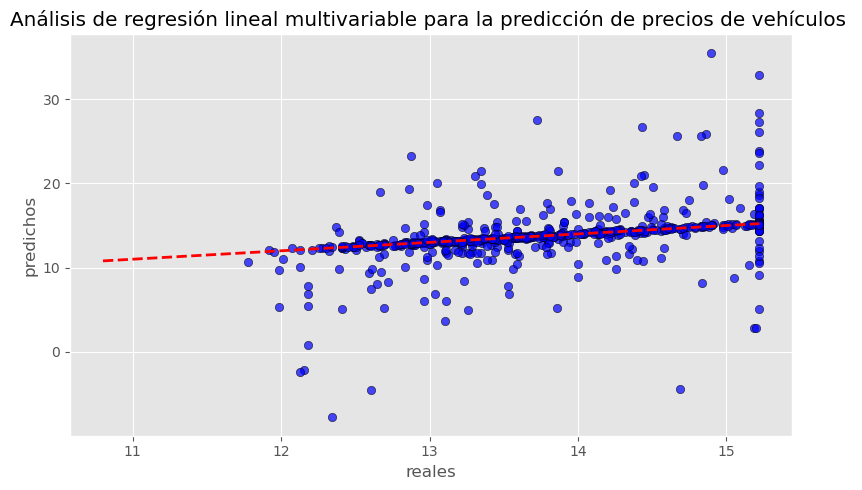

In [491]:
# Visualizar resultados

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("reales")
plt.ylabel("predichos")
plt.title("Análisis de regresión lineal multivariable para la predicción de precios de vehículos ")
plt.grid(True)
plt.tight_layout()
plt.show()


Hay una gran dispersión y los puntos se alejan de la línea roja, lo cual confirma que el  R² negativo del modelo no ajusta bien los datos , es probable que tenga problemas de multicolinealidad o variables irrelevantes.

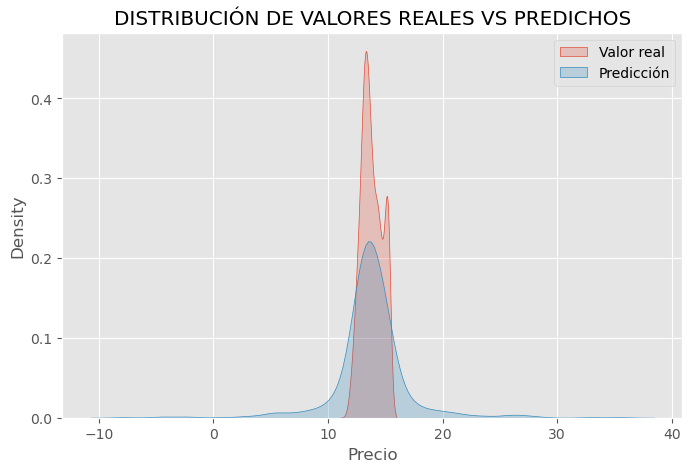

In [494]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Valor real', fill=True)
sns.kdeplot(y_pred, label='Predicción', fill=True)
plt.legend()
plt.title("DISTRIBUCIÓN DE VALORES REALES VS PREDICHOS")
plt.show()

1. vemos  que la distribución de precios reales (rojo) vs predichos (azul), La curva roja está más concentrada (más picos), mientras que la curva azul es más dispersa.

2. las predicciones del modelo no están capturando bien la variabilidad real del precio y están centradas pero subestiman o sobreestiman rangos importantes.

##### vamos a entrenar un nuevo modelo solo con las variables relevantes para ver si mejora el R²

datos que usaremos : "Kilometraje", "Propietario", "Tipo Vendedor", "Motor", "Potencia Máxima", "Torque Máximo", "Tracción",  "Ancho", "Altura", "Capacidad Pasajeros", "Capacidad Tanque"

In [499]:
# Separar variables
y_valor = data_limpia["Precio"]
x_valor = data_limpia[[
    #"Tipo Vendedor","Motor","Potencia Máxima","Ancho","Tracción","Altura","Torque Máximo"
    "Kilometraje", "Propietario", "Tipo Vendedor", "Motor", "Potencia Máxima", "Torque Máximo", "Tracción",  "Ancho", "Altura", "Capacidad Pasajeros", "Capacidad Tanque"
]]

# Codificar categóricas
X_encoded = pd.get_dummies(x_valor, drop_first=True)

# Entrenar y evaluar
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_valor, test_size=0.3, random_state=42)

modelo = LinearRegression()
modelo.fit(X_train, y_train)

y_pred = modelo.predict(X_test)

# Evaluar el modelo

print(f"\nIntercepto: {modelo.intercept_:.2f}")
print("Error cuadrático medio (MSE):", mean_squared_error(y_test, y_pred))
print("Coeficiente de determinación (R²):", r2_score(y_test, y_pred))

print("\nCoeficientes del modelo:")
for nombre, coef in zip(X.columns, modelo.coef_):
    print(f"{nombre}: {coef:.2f}")


Intercepto: 9.06
Error cuadrático medio (MSE): 0.10738702457872215
Coeficiente de determinación (R²): 0.8623249092032425

Coeficientes del modelo:
const: -0.00
Año: 0.00
Kilometraje: 0.00
Tipo Combustible: 0.00
Transmisión: 0.01
Ubicación: 1.05
Color: 0.38
Propietario: 0.99
Tipo Vendedor: 0.69
Motor: 1.30
Potencia Máxima: -0.36
Torque Máximo: -0.42
Tracción: -0.45
Longitud: -0.57
Ancho: -0.29
Altura: 0.14
Capacidad Pasajeros: -0.23
Capacidad Tanque: -0.28
Marca: -0.46
Modelo: -0.22


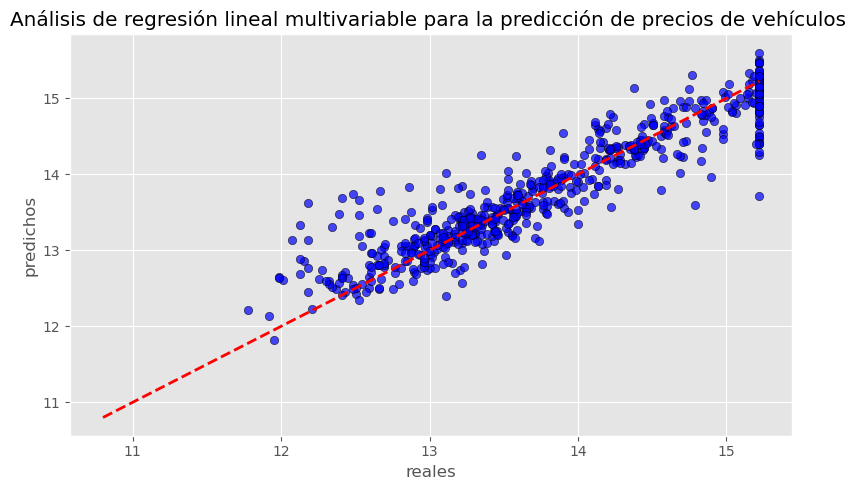

In [501]:
# Visualizar resultados

plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, color='blue', edgecolors='k', alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("reales")
plt.ylabel("predichos")
plt.title("Análisis de regresión lineal multivariable para la predicción de precios de vehículos ")
plt.grid(True)
plt.tight_layout()
plt.show()


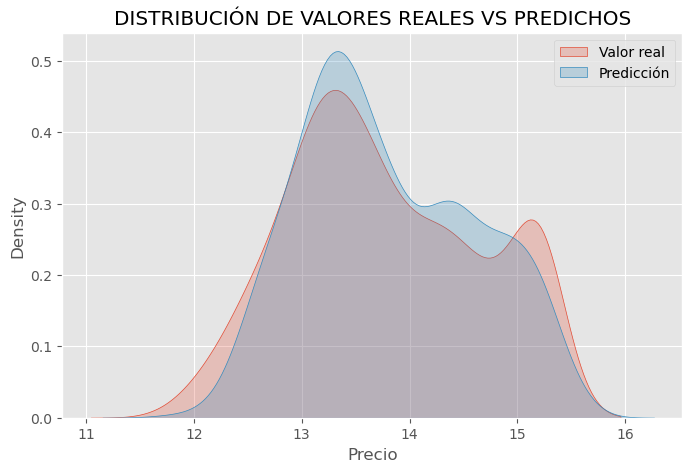

In [503]:
plt.figure(figsize=(8, 5))
sns.kdeplot(y_test, label='Valor real', fill=True)
sns.kdeplot(y_pred, label='Predicción', fill=True)
plt.legend()
plt.title("DISTRIBUCIÓN DE VALORES REALES VS PREDICHOS")
plt.show()

## conclucion:



1. al realizar los cambios  podemos notar que el coeficiente de determinación (R²) es igual a  0.8623 , esto se traduce en que el modelo explica el 86.23% de la variabilidad del precio (logarítmico), hemos obtenido un muy buen resultado  para el modelo de regresión lineal  , lo que da como resultado una alta correlación  entre los predictores seleccionados y el precio.
2. en la grafica de regresión lineal los puntos están alineados bastante bien a la diagonal roja (ideal), lo que indica buen ajuste del modelo.
3. en la grafica de distribución la curva azul (predicciones) y la roja (valores reales) están muy cerca, con una forma casi idéntica , significa que la distribución de los precios predichos sigue bien la forma real. 

## prueba para predecir precio

In [508]:
nuevo_auto = pd.DataFrame([{
    "Kilometraje": 45000,
    "Propietario": "Primer dueño",
    "Tipo Vendedor": "Particular",
    "Motor": 1.5,
    "Potencia Máxima": 100,
    "Torque Máximo": 150,
    "Tracción": "4x2",
    "Ancho": 1700,
    "Altura": 1500,
    "Capacidad Pasajeros": 5,
    "Capacidad Tanque": 45
}])
# Codificar con dummies
nuevo_auto_encoded = pd.get_dummies(nuevo_auto)

# Igualar columnas con las del modelo
nuevo_auto_encoded = nuevo_auto_encoded.reindex(columns=X_encoded.columns, fill_value=0)

# Predecir log(precio)
log_precio_predicho = modelo.predict(nuevo_auto_encoded)[0]

# Transformar a precio real
precio_predicho = np.exp(log_precio_predicho)

print(f"Precio estimado del vehículo: ${precio_predicho:,.0f}")

Precio estimado del vehículo: $457,794
